Loading the **iris dataset** and training a **random forest ensemble**, with:

*   50 decision trees trained on it (*n_estimators = 5*).
*   Using all available CPUs for running training processes in parallel (*n_jobs=-1*).

After training, we print the **features' names**, together with the resulting **importance weights** of each one, as calculated by the ensemble.

In [ ]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier

iris = load_iris()

rf_clf = RandomForestClassifier(n_estimators=5, n_jobs=-1)
rf_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rf_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.03968582691963677
sepal width (cm) 0.003557449434085958
petal length (cm) 0.4623457424915573
petal width (cm) 0.49441098115472004


It seems that *petal length and width* are by far the most relevant features in predicting the class of an iris observation.

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

predictions_tr = rf_clf.predict(iris["data"])
accuracy_score(iris["target"], predictions_tr)

0.9933333333333333

Obtain the **confusion matrix**, and a classification report that shows the **precision, recall and F1-score**.

In [ ]:
confusion_matrix(iris["target"], predictions_tr)

array([[50,  0,  0],
       [ 0, 49,  1],
       [ 0,  0, 50]])

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(iris["target"], predictions_tr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      0.98      0.99        50
           2       0.98      1.00      0.99        50

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(iris["target"], predictions_tr, pos_label=2)
roc_auc = auc(fpr, tpr)
roc_auc

0.995

Visualization of the **ROC Curve**

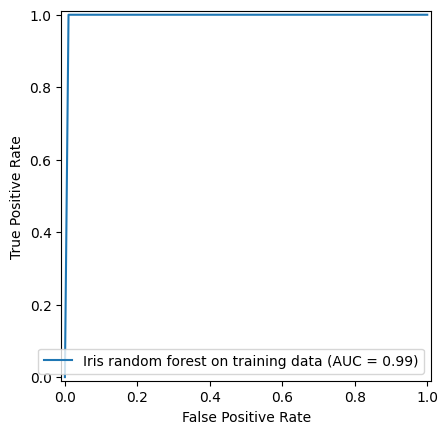

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='Iris random forest on training data')
display.plot()
plt.show()

**SAME EXAMPLE AGAIN, BUT SPLITTING BETWEEN TRAINING (70%) AND TEST DATA (30%) AND EVALUATING OVER THE TEST DATA**

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris["data"], iris["target"], test_size=.3, random_state=42)

rf_clf = RandomForestClassifier(n_estimators=5, n_jobs=-1)
rf_clf.fit(X_train, y_train)
for name, score in zip(iris["feature_names"], rf_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.14274842119676143
sepal width (cm) 0.03032311170672445
petal length (cm) 0.6178814737692871
petal width (cm) 0.20904699332722698


In [ ]:
predictions_test = rf_clf.predict(X_test)
accuracy_score(y_test, predictions_test)

1.0

In [ ]:
confusion_matrix(y_test, predictions_test)

array([[19,  0,  0],
       [ 0, 13,  0],
       [ 0,  0, 13]])

In [ ]:
print(classification_report(y_test, predictions_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



1.0


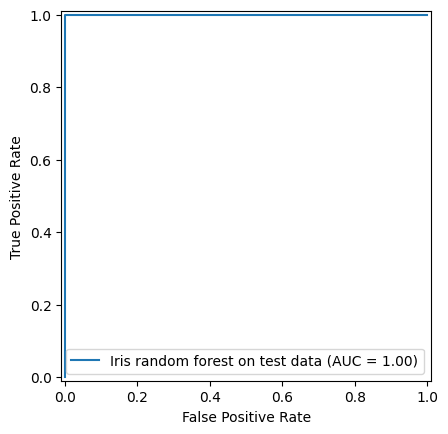

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, predictions_test, pos_label=2)
roc_auc = auc(fpr, tpr)
print(roc_auc)

display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='Iris random forest on test data')
display.plot()
plt.show()

Accuracy on test data can reach 100% due to a low amount of test data.

## Random Forest from scratch

### Create Decision Tree

In [ ]:
import numpy as np

class DecisionNode:
  def __init__(self, impurity=None, feature_index=None, threshold=None, left=None, right=None):
    self.left = left
    self.right = right
    # The largest impurity value of this node
    self.impurity = impurity
    # Index of the feature which make the best fit for this node.
    self.feature_index = feature_index
    # The threshold value for that feature to make the split.
    self.threshold = threshold

class LeafNode:
  def __init__(self, value):
    self.prediction_value = value

class DecisionTreeClassifierFromScratch:
  def __init__(self, min_sample_split=3, min_impurity=1e-7, max_depth=10, criterion='gini'):
    self.root = None
    self.min_sample_split = min_sample_split
    self.min_impurity = min_impurity
    self.max_depth = max_depth
    self.impurity_function = self._claculate_information_gain
    if criterion == 'entropy':
      self.criterion = self._entropy
      self.criterion_name = criterion
    else:
      self.criterion = self._gini_index
      self.criterion_name = 'gini'

  def _gini_index(self, y):
    gini = 1
    unique_value = np.unique(y)
    for val in unique_value:
      # probability of that class.
      p = np.sum(y == val) / len(y)
      gini += -np.square(p)
    return gini

  def _entropy(self, y):
    entropy = 0
    unique_value = np.unique(y)
    for val in unique_value:
      # probability of that class.
      p = np.sum(y == val) / len(y)
      entropy += -p * np.log2(p)
    return entropy

  def _claculate_information_gain(self, y, y1, y2):
    # :param y: target value.
    # :param y1: target value for dataset in the true split/right branch.
    # :param y2: target value for dataset in the false split/left branch.

    # propobility of true values.
    p = len(y1) / len(y)
    info_gain = self.criterion(y) - p * self.criterion(y1) - (1 - p) * self.criterion(y2)
    return info_gain

  def _leaf_value_calculation(self, y):
    most_frequent_label = None
    max_count = 0
    unique_labels = np.unique(y)
    # iterate over all the unique values and find their frequentcy count.
    for label in unique_labels:
      count = len( y[y == label])
      if count > max_count:
        most_frequent_label = label
        max_count = count
    return most_frequent_label

  def _partition_dataset(self, Xy, feature_index, threshold):
    col = Xy[:, feature_index]
    X_1 = Xy[col >= threshold]
    X_2 = Xy[col < threshold]

    return X_1, X_2

  def _find_best_split(self, Xy):
    best_question = tuple()
    best_datasplit = {}
    largest_impurity = 0
    n_features = (Xy.shape[1] - 1)
    # iterate over all the features.
    for feature_index in range(n_features):
      # find the unique values in that feature.
      unique_value = set(s for s in Xy[:,feature_index])
      # iterate over all the unique values to find the impurity.
      for threshold in unique_value:
        # split the dataset based on the feature value.
        true_xy, false_xy = self._partition_dataset(Xy, feature_index, threshold)

        # skip the node which has any on type 0. because this means it is already pure.
        if len(true_xy) > 0 and len(false_xy) > 0:
          # find the y values.
          y = Xy[:, -1]
          true_y = true_xy[:, -1]
          false_y = false_xy[:, -1]
          # calculate the impurity function.
          impurity = self.impurity_function(y, true_y, false_y)

          # if the calculated impurity is larger than save this value for comaparition (higest gain).
          if impurity > largest_impurity:
            largest_impurity = impurity
            best_question = (feature_index, threshold)
            best_datasplit = {
              "leftX": true_xy[:, :n_features],   # X of left subtree
              "lefty": true_xy[:, n_features:],   # y of left subtree
              "rightX": false_xy[:, :n_features],  # X of right subtree
              "righty": false_xy[:, n_features:]   # y of right subtree
            }

    return largest_impurity, best_question, best_datasplit

  def _build_tree(self, X, y, current_depth=0):
    n_samples , n_features = X.shape
    # Add y as last column of X
    Xy = np.column_stack((X, y))
    # find the Information gain on each feature each values and return the question which splits the data very well
    if (n_samples >= self.min_sample_split) and (current_depth < self.max_depth):
      # find the best split/ which question split the data well.
      impurity, quesion, best_datasplit = self._find_best_split(Xy)
      if impurity > self.min_impurity:
        # Build subtrees for the right and left branch.
        true_branch = self._build_tree(best_datasplit["leftX"], best_datasplit["lefty"], current_depth + 1)
        false_branch = self._build_tree(best_datasplit["rightX"], best_datasplit["righty"], current_depth + 1)
        return DecisionNode(impurity=impurity, feature_index=quesion[0], threshold=quesion[1],
                            left=true_branch, right=false_branch)

    leaf_value = self._leaf_value_calculation(y)
    return LeafNode(value=leaf_value)

  def fit(self, X, y):
    self.root = self._build_tree(X, y, current_depth=0)

  def predict_sample(self, x, tree=None):
    if isinstance(tree , LeafNode):
      return tree.prediction_value

    if tree is None:
      tree = self.root
    feature_value = x[tree.feature_index]
    branch = tree.right

    if isinstance(feature_value, int) or isinstance(feature_value, float):
      if feature_value >= tree.threshold:
        branch = tree.left
    elif feature_value == tree.threshold:
      branch = tree.left

    return self.predict_sample(x, branch)

  def predict(self, test_X):
    x = np.array(test_X)
    y_pred = [self.predict_sample(sample) for sample in x]
    y_pred = np.array(y_pred)
    return y_pred

  def draw_tree(self):
    self._draw_tree(self.root)

  def _draw_tree(self, tree = None, indentation = " ", depth=0):
    if isinstance(tree , LeafNode):
      print(indentation,"The predicted value -->", tree.prediction_value)
      return
    else:
      print(indentation,f"({depth}) Is {tree.feature_index}>={tree.threshold}?"
            f": {self.criterion_name}:{tree.impurity:.2f}")
      if tree.left is not None:
          print (indentation + '----- True branch :)')
          self._draw_tree(tree.left, indentation + "  ", depth+1)
      if tree.right is not None:
          print (indentation + '----- False branch :)')
          self._draw_tree(tree.right, indentation + "  ", depth+1)

### Create Random Forest

In [ ]:
class RandomForestClassifierFromScratch:
  def __init__(self, max_feature=None, n_trees=100, min_sample_split=2, min_impurity=1e-7, max_depth=10, criterion='gini'):
    # Initialize the trees.
    self.trees = []
    for _ in range(n_trees):
      self.trees.append(DecisionTreeClassifierFromScratch(min_sample_split=min_sample_split,min_impurity=min_impurity,
                                                          max_depth=max_depth,criterion=criterion))

    self.tree_feature_indexes = []
    # Number of trees/estimetors.
    self.n_estimators = n_trees
    # How many features can be used for a tree from the whole features.
    self.max_features = max_feature
    # Aggication function to find the prediction.
    self.prediction_aggrigation_calculation = self._maximum_vote_calculation

  def _maximum_vote_calculation(self, y_preds):
    # Find which prediction class has higest frequency in all tree prediction for each sample.
    # create a empty array to store the prediction.
    y_pred = np.empty((y_preds.shape[0], 1))
    # iterate over all the data samples.
    for i, sample_predictions in enumerate(y_preds):
      y_pred[i] = np.bincount(sample_predictions.astype('int')).argmax()

    return y_pred

  def _make_random_subset(self, X, y, n_subsets, replacement=True):
    # Create a random subset of dataset with/without replacement.
    subset = []
    # use 100% of data when replacement is true , use 50% otherwise.
    sample_size = (X.shape[0] if replacement else (X.shape[0] // 2))

    # Add y as last column of X
    Xy = np.column_stack((X, y))
    np.random.shuffle(Xy)
    # Select randome subset of data with replacement.
    for i in range(n_subsets):
      index = np.random.choice(range(sample_size), size=np.shape(range(sample_size)), replace=replacement)
      X = Xy[index][:, :-1]
      y = Xy[index][: , -1]
      subset.append({"X" : X, "y": y})
    return subset

  def fit(self, X, y):
    # if the max_features is not given then select it as square root of no on feature availabe.
    n_features = X.shape[1]
    if self.max_features == None:
      self.max_features = int(round(np.sqrt(n_features)))

    # Split the dataset into number of subsets equal to n_estimators.
    subsets = self._make_random_subset(X, y, self.n_estimators)

    for i, subset in enumerate(subsets):
      X_subset , y_subset = subset["X"], subset["y"]
      # select a random sucset of features for each tree. This is called feature bagging.
      idx = np.random.choice(range(n_features), size=self.max_features, replace=True)
      # track this for prediction.
      self.tree_feature_indexes.append(idx)
      # Get the X with the selected features only.
      X_subset = X_subset[:, idx]

      # change the y_subet to i dimentional array.
      y_subset = np.expand_dims(y_subset, axis =1)
      # build the model with selected features and selected random subset from dataset.
      self.trees[i].fit(X_subset, y_subset)

  def predict(self, test_X):
    y_preds = np.empty((test_X.shape[0], self.n_estimators))
    # find the prediction from each tree for each samples
    for i, tree in enumerate(self.trees):
      features_index = self.tree_feature_indexes[i]
      X_selected_features = test_X[:, features_index]
      if isinstance(tree, DecisionTreeClassifier):
        y_preds[:, i] = tree.predict(X_selected_features).reshape((-1,))
      else:
        y_preds[:, i] = tree.predict(X_selected_features)
    # find the aggregated output.
    y_pred = self.prediction_aggrigation_calculation(y_preds)

    return y_pred

### Test from scratch

In [ ]:
from sklearn.datasets import load_iris
import pandas as pd

iris = load_iris()
X = iris.data
y = iris.target

Test Decision Tree from scratch

In [ ]:
# From scratch
from sklearn.metrics import accuracy_score
tree = DecisionTreeClassifierFromScratch(min_sample_split=1, max_depth=3, criterion="gini")
tree.fit(X, y)
sc_t_pred = tree.predict(X)

tree.draw_tree()

print(accuracy_score(y, sc_t_pred))

  (0) Is 2>=3.0?: gini:0.33
 ----- True branch :)
    (1) Is 3>=1.8?: gini:0.39
   ----- True branch :)
      (2) Is 2>=4.9?: gini:0.01
     ----- True branch :)
        The predicted value --> 2.0
     ----- False branch :)
        The predicted value --> 2.0
   ----- False branch :)
      (2) Is 2>=5.0?: gini:0.08
     ----- True branch :)
        The predicted value --> 2.0
     ----- False branch :)
        The predicted value --> 1.0
 ----- False branch :)
    The predicted value --> 0.0
0.9733333333333334


In [ ]:
# From Scikit-learn
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=3, criterion="gini")
tree.fit(X, y)
y_t_pred = tree.predict(X)

accuracy_score(y, y_t_pred)

0.9733333333333334

Test Random Forest from scratch

In [ ]:
# From Scratch
rf = RandomForestClassifierFromScratch(n_trees=10, criterion="entropy")
rf.fit(X, y)
sc_rf_pred = rf.predict(X)

accuracy_score(y, sc_rf_pred)

0.9933333333333333

In [ ]:
# From Scikit-learn
from sklearn.ensemble import RandomForestClassifier
rf_pg = RandomForestClassifier(n_estimators=10, criterion='entropy', n_jobs=-1)
rf_pg.fit(X, y)
y_rf_pred = rf_pg.predict(X)

print(accuracy_score(y, y_rf_pred))

1.0


# Exercise - Penguins dataset

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp /content/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download parulpandey/palmer-archipelago-antarctica-penguin-data
! unzip palmer-archipelago-antarctica-penguin-data.zip

cp: cannot stat '/content/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/parulpandey/palmer-archipelago-antarctica-penguin-data
License(s): CC0-1.0
  0% 0.00/11.3k [00:00<?, ?B/s]
100% 11.3k/11.3k [00:00<00:00, 19.9MB/s]
Archive:  palmer-archipelago-antarctica-penguin-data.zip
  inflating: penguins_lter.csv       
  inflating: penguins_size.csv       


In [ ]:
import pandas as pd
penguins = pd.read_csv('penguins_size.csv').dropna()
penguins.info()

<class 'pandas.core.frame.DataFrame'>
Index: 334 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            334 non-null    object 
 1   island             334 non-null    object 
 2   culmen_length_mm   334 non-null    float64
 3   culmen_depth_mm    334 non-null    float64
 4   flipper_length_mm  334 non-null    float64
 5   body_mass_g        334 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 20.9+ KB


In [ ]:
penguins.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE


In [ ]:
penguins.island = pd.factorize(penguins.island)[0]
penguins.sex = pd.factorize(penguins.sex)[0]

penguins.dropna()
penguins

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,0,39.1,18.7,181.0,3750.0,0
1,Adelie,0,39.5,17.4,186.0,3800.0,1
2,Adelie,0,40.3,18.0,195.0,3250.0,1
4,Adelie,0,36.7,19.3,193.0,3450.0,1
5,Adelie,0,39.3,20.6,190.0,3650.0,0
...,...,...,...,...,...,...,...
338,Gentoo,1,47.2,13.7,214.0,4925.0,1
340,Gentoo,1,46.8,14.3,215.0,4850.0,1
341,Gentoo,1,50.4,15.7,222.0,5750.0,0
342,Gentoo,1,45.2,14.8,212.0,5200.0,1


In [ ]:
penguins = pd.read_csv('penguins_size.csv').dropna()
# Separate predictor variables from class label
# For predictor attributes, we only keep numerical and exclude categorical ones
penguins.island = pd.factorize(penguins.island)[0]
penguins.sex = pd.factorize(penguins.sex)[0]
X = penguins.select_dtypes(exclude=['object'])  #remove object column (non-number)
y = penguins.species.astype('category').cat.codes  # predict classes

# Create training and test sets
# Random state for reproducibility in experiments = 52
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=52)

### Decision Tree Model for penguins dataset

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=3, criterion='entropy')
tree.fit(X_train, y_train)

# Making predictions on test data
predictions = tree.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print(accuracy_score(y_test, predictions))

print(confusion_matrix(y_test, predictions))

print(classification_report(y_test, predictions))

0.9801980198019802
[[46  0  0]
 [ 2 16  0]
 [ 0  0 37]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        46
           1       1.00      0.89      0.94        18
           2       1.00      1.00      1.00        37

    accuracy                           0.98       101
   macro avg       0.99      0.96      0.97       101
weighted avg       0.98      0.98      0.98       101



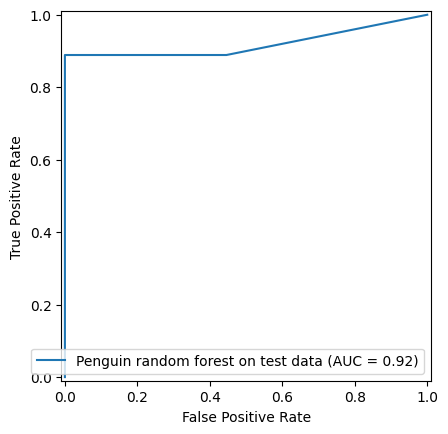

In [ ]:
fpr, tpr, thresholds = roc_curve(pd.factorize(y_test)[0], pd.factorize(predictions)[0], pos_label=2)
roc_auc = auc(fpr, tpr)

display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='Penguin random forest on test data')
display.plot()
plt.show()

### Random Forest for penguins dataset

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Make 10 trees in the forest
rf_pg = RandomForestClassifier(n_estimators=10, criterion='entropy', n_jobs=-1)
rf_pg.fit(X_train, y_train)
rf_pred = rf_pg.predict(X_test)

print(accuracy_score(y_test, rf_pred))

print(confusion_matrix(y_test, rf_pred))

print(classification_report(y_test, rf_pred))

1.0
[[46  0  0]
 [ 0 18  0]
 [ 0  0 37]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        46
           1       1.00      1.00      1.00        18
           2       1.00      1.00      1.00        37

    accuracy                           1.00       101
   macro avg       1.00      1.00      1.00       101
weighted avg       1.00      1.00      1.00       101



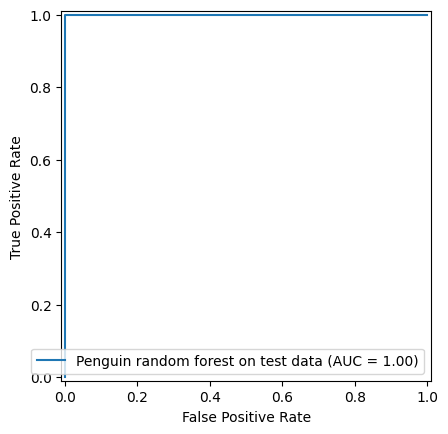

In [ ]:
fpr, tpr, thresholds = roc_curve(pd.factorize(y_test)[0], pd.factorize(rf_pred)[0], pos_label=2)
roc_auc = auc(fpr, tpr)

display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='Penguin random forest on test data')
display.plot()
plt.show()

# Optional
if the penguins dataset won't factorize the object artribute, try OneHotEncoder()

In [ ]:
# ----------Optional----------
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
pg = pd.read_csv('penguins_size.csv').dropna()
X = pg.drop(['species'], axis=1)
y = pg.species
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=52)
encoder.fit(X_train[['island']])
X_train_encoded = encoder.transform(X_train[['island']]).toarray()
X_train_encoded_df = pd.DataFrame(X_train_encoded,\
                                  columns=encoder.get_feature_names_out(X_train[['island']].columns)
                                  )
X_train_encoded_df.head()

,island_Biscoe,island_Dream,island_Torgersen
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0


In [ ]:
#adding new data cleaning column to table
X_train_n = X_train.drop(['island','sex'], axis=1)
X_train_n.reset_index(drop=True, inplace=True)

X_train_encoded_df.reset_index(drop=True, inplace=True)

X_train_prepared = pd.concat([X_train_n, X_train_encoded_df], axis=1)
X_train_prepared.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,island_Biscoe,island_Dream,island_Torgersen
0,49.6,16.0,225.0,5700.0,1.0,0.0,0.0
1,46.5,14.8,217.0,5200.0,1.0,0.0,0.0
2,39.5,17.8,188.0,3300.0,0.0,1.0,0.0
3,43.3,13.4,209.0,4400.0,1.0,0.0,0.0
4,46.2,14.9,221.0,5300.0,1.0,0.0,0.0


In [ ]:
print(y_train.unique())
# y_train.head()

['Gentoo' 'Adelie' 'Chinstrap']


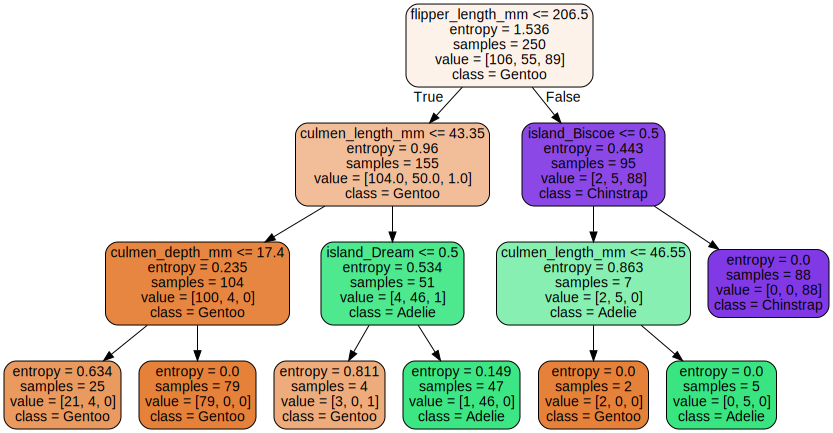

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=3, criterion='entropy')
tree.fit(X_train_prepared, y_train)

from sklearn.tree import export_graphviz
from graphviz import Source

import os
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "tree images")
os.makedirs(IMAGES_PATH, exist_ok=True)

export_graphviz(
    tree, # Our model learnt
    out_file = os.path.join(IMAGES_PATH, "penguins_tree_01.dot"),
    feature_names = X_train_prepared.columns,
    class_names = y_train.unique(),
    rounded = True,
    filled = True
)
Source.from_file(os.path.join(IMAGES_PATH, "penguins_tree_01.dot"))

In [ ]:
X_test_encoded = encoder.transform(X_test[['island']]).toarray()
X_test_encoded_df = pd.DataFrame(X_test_encoded,\
                                  columns=encoder.get_feature_names_out(X_test[['island']].columns)
                                  )
X_test_n = X_test.drop(['island','sex'], axis=1)
X_test_n.reset_index(drop=True, inplace=True)
X_test_encoded_df.reset_index(drop=True, inplace=True)

X_test_prepared = pd.concat([X_test_n, X_test_encoded_df], axis=1)
X_test_prepared.head()
test_pred = tree.predict(X_test_prepared)

print(accuracy_score(y_test, test_pred))

print(confusion_matrix(y_test, test_pred))

print(classification_report(y_test, test_pred))

0.9880952380952381
[[40  0  0]
 [ 1 12  0]
 [ 0  0 31]]
              precision    recall  f1-score   support

      Adelie       0.98      1.00      0.99        40
   Chinstrap       1.00      0.92      0.96        13
      Gentoo       1.00      1.00      1.00        31

    accuracy                           0.99        84
   macro avg       0.99      0.97      0.98        84
weighted avg       0.99      0.99      0.99        84



['Adelie' 'Gentoo' 'Chinstrap']
[0 1 2]


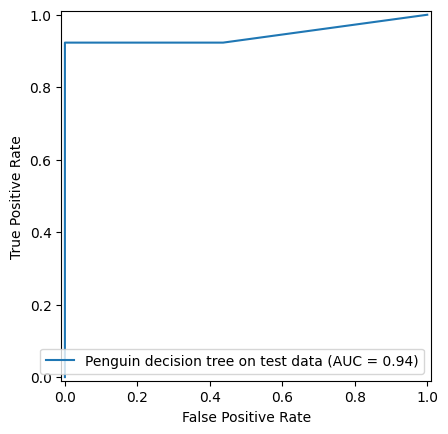

In [ ]:
print(y_test.unique())
# roc_curve(...) does not accept string, turn pred and class into number
print(pd.factorize(y_test.unique())[0])
fpr, tpr, thresholds = roc_curve(pd.factorize(y_test)[0], pd.factorize(test_pred)[0], pos_label=2)

roc_auc = auc(fpr, tpr)
roc_auc

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='Penguin decision tree on test data')
display.plot()
plt.show()

# Homework

จาก Dataset ที่สร้างขึ้นมาจาก W4-1 decision tree จงสร้าง Random Forest Classifier Model เพื่อทำการทดลองปรับค่า

n_estimators (จำนวนของ Decision Trees / Estimators ที่อยู่ใน Forest) และ max_depth (ความลึกของ Decision Trees) โดยตั้งค่า Model เป็นดังนี้
  1. ปรับใช้ค่า n_estimators เป็นค่าในช่วงตั้งแต่ 1 - 15
  2. ปรับใช้ค่า max_depth เป็นค่าใน [2, 4, 6, 8, 10, 12]
  3. ตั้งค่า criterion = 'entropy'
  5. ตั้งค่า random_state = 56

ค่า Accuracy ที่ดีที่สุดคือค่าใด และมีค่า n_estimators และ max_depth เป็นค่าใด

อธิบายผลที่เกิดขึ้นหลังปรับค่า n_estimators และ max_depth ให้เพิ่มขึ้น

``` python
'''
    Arg เดิมที่ว่า:
        X = cancer.data[:, :5] #Calculated by mean of radius & texture of cancer point
        y = cancer.target #To distinguish malignant (ก้อนเนื้อร้าย/Bad tumor/cancer/1) or benign (ก้อนเนื้องอกที่ไม่อันตราย/Non-cancer/0)
'''

def rf_estimators_test(dataset, range_estimator_params, range_depth_params, random_state=56):
  X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, test_size=0.25, random_state=random_state)
  best_acc = 0.
  best_n_estimator = 0
  best_depth = 0
  for i in range(*range_estimator_params):
    print("n_estimators:",i)
    for j in range(*range_depth_params):
      # สร้าง Model และ ทำการ predict
      # rf_clf =
      # ...
      # rf_pred =
      accuracy = accuracy_score(y_test, rf_pred)
      print("depth:",j,"acc:",f'{accuracy:.3f}',end=' | ')
      if (accuracy > best_acc):
        best_acc = accuracy
        best_n_estimator = i
        best_depth = j
    print()
  print('best -> acc:',best_acc,'n_estimator:',best_n_estimator,'depth:',best_depth)

re_params = (0, 0)    # ปรับตัวแปรของ n_estimators -> range(start, stop)
rd_params = (0, 0, 0) # ปรับตัวแปรของ max_depth -> range(start, stop, step)
rf_estimators_test(experiment_dataset, re_params, rd_params)
```